In [8]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

def mean_portfolio(weights, *dataopt):
    """Calculate portfolio return"""
    mean_returns = dataopt[0]  # This is the array of expected returns for each asset
    portfolio_return = mean_returns.dot(weights)
    return portfolio_return

def std_portfolio(weights, *dataopt):
    """Calculate portfolio volatility (standard deviation)"""
    annualized_returns = dataopt[0]
    # Compute correlation matrix
    correlation_matrix = dataopt[1] 

    # Compute standard deviation (volatility)
    individual_volatility = dataopt[2]

    # Convert to diagonal matrix
    D = np.diag(individual_volatility)

    # Compute covariance matrix
    cov_annualized_returns = np.dot(D, np.dot(correlation_matrix, D)) * 12
    
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annualized_returns, weights)))

    return portfolio_volatility

def sharpe_ratio(weights, *dataopt):
    """Calculate Sharpe Ratio"""
    mean_returns = dataopt[0]  # Expected annual returns (array)
    correlation_matrix = dataopt[1]  # Correlation matrix of asset returns
    individual_volatility = dataopt[2]  # Standard deviation (volatility) of each asset

    # Calculate portfolio return
    portfolio_return = np.dot(weights, mean_returns)

    # Convert individual volatilities to a diagonal matrix
    D = np.diag(individual_volatility)

    # Compute covariance matrix using correlation and standard deviations
    cov_annualized_returns = np.dot(D, np.dot(correlation_matrix, D)) * 12  # Annualized covariance

    # Compute portfolio volatility
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annualized_returns, weights)))

    # Compute Sharpe Ratio
    sharpe = portfolio_return / portfolio_volatility
    return sharpe  # No negation since maximization is handled separately




def portfolio_optimization(monthly_returns, stock, last_month_volatility):
    """Optimize portfolio using Sharpe Ratio maximization"""
    annual_trading_months = 12
    observed_trading_months = monthly_returns.shape[0]
    
    # Annualized returns
    annualized_returns = (1 + monthly_returns).prod() ** (annual_trading_months / observed_trading_months) - 1

    # Annualized covariance matrix
    volatility = last_month_volatility
    cor_returns = monthly_returns.corr()
    
    # Prepare optimization inputs
    dataopt = (annualized_returns, cor_returns, volatility)
    num_assets = len(annualized_returns)
    
    # Initial equal weights
    initial_weights = np.ones(num_assets) / num_assets
    
    # Bounds (weights between 0 and 1 for long-only portfolios)
    bounds = [(0, 1) for _ in range(num_assets)]
    
    # Constraint: Sum of weights must be 1
    constraints = [
    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Portfolio weights must sum to 1
    {'type': 'ineq', 'fun': lambda x: 1 - np.sum(x)}  # Ensure portfolio weight is less than 100%
    ]

    
    # Perform optimization
    result = minimize(
        fun=lambda x, *dataopt: -sharpe_ratio(x, *dataopt),  # Negate return for maximization
        x0=initial_weights,
        args=dataopt,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )

    storeoptimal_weights = dict(zip(stock, result.x))  # Assuming 'stocks' contains your stock names

    # Convert to DataFrame
    storeweights_df = pd.DataFrame.from_dict(
        storeoptimal_weights, 
        orient='index', 
        columns=['Optimal Weight']
    )
    
    optimal_weights = dict(zip(stock, result.x))
    print("Optimal Portfolio Allocation max SR")
    for asset, weight in optimal_weights.items():
        print(f"{asset}: {weight:.2%}")  # Display as percentage with 2 decimal places
    
    # Portfolio metrics
    portfolio_return = mean_portfolio(result.x, *dataopt)
    portfolio_volatility = std_portfolio(result.x, *dataopt)
    sharpe = portfolio_return / portfolio_volatility
    
    print(f"\nExpected Annual Return: {portfolio_return:.2%}")
    print(f"Annual Volatility: {portfolio_volatility:.2%}")
    print(f"Sharpe Ratio: {sharpe:.2f}")

    return sharpe, storeweights_df # Return optimal allocation

    
    # to use just write (optimal_weights = portfolio_optimization(sample_data))
    # sample_data is monthly return data


In [9]:

def entire_portfolio_optimization(monthly_returns):
    """Optimize portfolio using Sharpe Ratio maximization"""
    annual_trading_months = 12
    observed_trading_months = monthly_returns.shape[0]
    
    # Annualized returns
    annualized_returns = (1 + monthly_returns).prod() ** (annual_trading_months / observed_trading_months) - 1

    # Annualized covariance matrix
    volatility = np.sqrt(annual_trading_months)*monthly_returns.std()
    cor_returns = monthly_returns.corr()
    
    # Prepare optimization inputs
    dataopt = (annualized_returns, cor_returns, volatility)
    num_assets = len(annualized_returns)
    
    # Initial equal weights
    initial_weights = np.ones(num_assets) / num_assets
    
    # Bounds (weights between 0 and 1 for long-only portfolios)
    bounds = [(0, 1) for _ in range(num_assets)]
    
    # Constraint: Sum of weights must be 1
    constraints = [
    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Portfolio weights must sum to 1
    {'type': 'ineq', 'fun': lambda x: 1 - np.sum(x)}  # Ensure portfolio weight is less than 100%
    ]

    
    # Perform optimization
    result = minimize(
        fun=lambda x, *dataopt: -sharpe_ratio(x, *dataopt),  # Negate return for maximization
        x0=initial_weights,
        args=dataopt,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )


    

    print("Optimal Portfolio Allocation max SR")
    
    # Portfolio metrics
    portfolio_return = mean_portfolio(result.x, *dataopt)
    portfolio_volatility = std_portfolio(result.x, *dataopt)
    sharpe = portfolio_return / portfolio_volatility
    
    print(f"\nExpected Annual Return: {portfolio_return:.2%}")
    print(f"Annual Volatility: {portfolio_volatility:.2%}")
    print(f"Sharpe Ratio: {sharpe:.2f}")

    return sharpe


In [10]:
import pandas as pd

# Function to pivot and replace NaN with 0
def pivot_and_fill(df, value_column):
    """Pivot the DataFrame and replace NaN with 0"""
    return df.pivot_table(
        index='Date',
        columns='Stock',
        values=value_column,
        aggfunc='first'
    ).fillna(0)  # This converts NaN to 0
    
def get_top10_by_market_cap(cluster_df):
    return (
        cluster_df.sort_values('Company Market Cap', ascending=False)
        .head(10)
        .reset_index(drop=True)
    )

    
def add_market_cap_to_cluster(cluster_df, market_cap_df):
    """Merge cluster_df with market_cap_df to add 'Company Market Cap'."""
    return cluster_df.merge(
        market_cap_df,
        on='Stock',
        how='left'  # Keep all stocks even if market cap is missing
    )

def merging_data(return_cluster,date_str):


# 1. Load and prepare three_ff data
    three_ff = pd.read_csv("three_ff_cleaned_df.csv")
     # Convert dates and filter range
    three_ff['Date'] = pd.to_datetime(three_ff['Date'], format='%d-%m-%Y')

    actual_three_ff = three_ff[(three_ff['Date'] >= '2022-01-01') & 
                       (three_ff['Date'] <= pd.to_datetime(date_str))]

    # 2. Melt to match cluster format
    actual_three_ff_melted = actual_three_ff.melt(
        id_vars=['Date'],
        var_name='Stock',
        value_name='ActualReturn'
    )

    entire_three_ff = actual_three_ff_melted.copy()
    entire_three_ff = entire_three_ff.pivot(
        index='Date',
        columns='Stock',
        values='ActualReturn'
    )

    entire_three_ff = entire_three_ff / 100
    
    
    # 3. Filter for Cluster 0 stocks only
    cluster0_stocks = return_cluster.columns.tolist()
    actual_three_ff_filtered = actual_three_ff_melted[actual_three_ff_melted['Stock'].isin(cluster0_stocks)]

    # 4. Pivot to wide format
    actual_three_ff_pivoted = actual_three_ff_filtered.pivot(
        index='Date',
        columns='Stock',
        values='ActualReturn'
    )

    
    
    three_ff = three_ff[(three_ff['Date'] >= '2022-01-01') & 
                       (three_ff['Date'] <= '2023-12-31')]
    
    # 2. Melt to match cluster format
    three_ff_melted = three_ff.melt(
        id_vars=['Date'],
        var_name='Stock',
        value_name='PredictedReturn'
    )
    
    # 3. Filter for Cluster 0 stocks only
    cluster0_stocks = return_cluster.columns.tolist()
    three_ff_filtered = three_ff_melted[three_ff_melted['Stock'].isin(cluster0_stocks)]
    
    # 4. Pivot to wide format
    three_ff_pivoted = three_ff_filtered.pivot(
        index='Date',
        columns='Stock',
        values='PredictedReturn'
    )
    
    # 5. Ensure return_cluster0 has DateTimeIndex
    return_cluster.index = pd.to_datetime(return_cluster.index)

    # 6. Combine DataFrames
    combined_df = pd.concat([three_ff_pivoted, return_cluster])
    
    # 7. Final processing
    combined_df = combined_df.sort_index()
    combined_df = combined_df.apply(pd.to_numeric, errors='coerce')
    
    return combined_df, actual_three_ff_pivoted


    
def cluster_defining(date_str):

    # Read clustered data
    clustered_df = pd.read_csv(r"Output/models/clustered_df.csv")

    desired_columns = ['Date', 'Stock', 'PredictedReturn', 'PredictedVolatility', 'Cluster']
    clustered_df = clustered_df.reindex(columns=desired_columns)
    
    # Decrement Cluster values by 1 (1→0, 2→1, 3→2, 4→3)
    clustered_df['Cluster'] = clustered_df['Cluster'] - 1
    
    # Format numeric display
    pd.set_option('display.float_format', '{:.8f}'.format)
    
    # Display the modified DataFrame
    print(clustered_df)

    # Convert 'Date' column to datetime objects
    clustered_df['Date'] = pd.to_datetime(clustered_df['Date'])

    # Filter data for the specific date
    filtered_df = clustered_df[clustered_df['Date'] == pd.to_datetime(date_str)]

    # Create dataframes for each cluster
    df_cluster0 = filtered_df[filtered_df['Cluster'] == 0]
    df_cluster1 = filtered_df[filtered_df['Cluster'] == 1]
    df_cluster2 = filtered_df[filtered_df['Cluster'] == 2]
    df_cluster3 = filtered_df[filtered_df['Cluster'] == 3]

    # Read the clustered data CSV file
    merged_df = pd.read_csv(r"Output/models/merged_data.csv")
    merged_df['Period'] = pd.to_datetime(merged_df['Period'])
    
    # Filter for 2024-10-31 data only
    oct_2024_data = merged_df[merged_df['Period'] == pd.to_datetime(date_str)]
    
    # Select only 'RIC' and 'Company Market Cap' columns and rename RIC to Stock
    mktfiltered_data = oct_2024_data[['RIC', 'Company Market Cap']].rename(columns={'RIC': 'Stock'})
    


        # Apply to all clusters (replace df_cluster0, df_cluster1, etc. with your actual DataFrames)
    df_cluster0_with_cap = add_market_cap_to_cluster(df_cluster0, mktfiltered_data)
    df_cluster1_with_cap = add_market_cap_to_cluster(df_cluster1, mktfiltered_data)
    df_cluster2_with_cap = add_market_cap_to_cluster(df_cluster2, mktfiltered_data)
    df_cluster3_with_cap = add_market_cap_to_cluster(df_cluster3, mktfiltered_data)
    
        # Apply to all clusters
    top10_cluster0 = get_top10_by_market_cap(df_cluster0_with_cap)
    top10_cluster1 = get_top10_by_market_cap(df_cluster1_with_cap)
    top10_cluster2 = get_top10_by_market_cap(df_cluster2_with_cap)
    top10_cluster3 = get_top10_by_market_cap(df_cluster3_with_cap)

        # 1. Get the list of top 10 stocks from each cluster
    top10_stocks_cluster0 = top10_cluster0['Stock'].unique().tolist()
    top10_stocks_cluster1 = top10_cluster1['Stock'].unique().tolist()
    top10_stocks_cluster2 = top10_cluster2['Stock'].unique().tolist()
    top10_stocks_cluster3 = top10_cluster3['Stock'].unique().tolist()
    
    # 2. Filter the original clustered_df for each cluster's top 10 stocks AND date <= target_date
    alldate_cluster0 = clustered_df[
        (clustered_df['Stock'].isin(top10_stocks_cluster0)) & 
        (clustered_df['Date'] <= pd.to_datetime(date_str))
    ].drop(columns=['Cluster'])
    
    alldate_cluster1 = clustered_df[
        (clustered_df['Stock'].isin(top10_stocks_cluster1)) & 
        (clustered_df['Date'] <= pd.to_datetime(date_str))
    ].drop(columns=['Cluster'])
    
    alldate_cluster2 = clustered_df[
        (clustered_df['Stock'].isin(top10_stocks_cluster2)) & 
        (clustered_df['Date'] <= pd.to_datetime(date_str))
    ].drop(columns=['Cluster'])
    
    alldate_cluster3 = clustered_df[
        (clustered_df['Stock'].isin(top10_stocks_cluster3)) & 
        (clustered_df['Date'] <= pd.to_datetime(date_str))
    ].drop(columns=['Cluster'])

    
    # 3. Reset index for clean numbering
    alldate_cluster0.reset_index(drop=True, inplace=True)
    alldate_cluster1.reset_index(drop=True, inplace=True)
    alldate_cluster2.reset_index(drop=True, inplace=True)
    alldate_cluster3.reset_index(drop=True, inplace=True)
    

    
        # Process PredictedReturn (with NaN→0)
    return_cluster0 = pivot_and_fill(alldate_cluster0[['Date', 'Stock', 'PredictedReturn']], 'PredictedReturn')
    return_cluster1 = pivot_and_fill(alldate_cluster1[['Date', 'Stock', 'PredictedReturn']], 'PredictedReturn')
    return_cluster2 = pivot_and_fill(alldate_cluster2[['Date', 'Stock', 'PredictedReturn']], 'PredictedReturn')
    return_cluster3 = pivot_and_fill(alldate_cluster3[['Date', 'Stock', 'PredictedReturn']], 'PredictedReturn')
    
    # Process PredictedVolatility (with NaN→0)
    volatility_cluster0 = pivot_and_fill(alldate_cluster0[['Date', 'Stock', 'PredictedVolatility']], 'PredictedVolatility')
    volatility_cluster1 = pivot_and_fill(alldate_cluster1[['Date', 'Stock', 'PredictedVolatility']], 'PredictedVolatility')
    volatility_cluster2 = pivot_and_fill(alldate_cluster2[['Date', 'Stock', 'PredictedVolatility']], 'PredictedVolatility')
    volatility_cluster3 = pivot_and_fill(alldate_cluster3[['Date', 'Stock', 'PredictedVolatility']], 'PredictedVolatility')
    



        # Assuming volatility_cluster0, volatility_cluster1, etc. are pandas DataFrames
    endvol0 = volatility_cluster0.iloc[-1, :]  # Get the last row
    endvol1 = volatility_cluster1.iloc[-1, :]
    endvol2 = volatility_cluster2.iloc[-1, :]
    endvol3 = volatility_cluster3.iloc[-1, :]

    mergedcluster0, actualmerged0 = merging_data(return_cluster0,date_str)
    mergedcluster1, actualmerged1 = merging_data(return_cluster1,date_str)
    mergedcluster2, actualmerged2 = merging_data(return_cluster2,date_str)
    mergedcluster3, actualmerged3 = merging_data(return_cluster3,date_str)


    mergedcluster0 = mergedcluster0/100 
    mergedcluster1 = mergedcluster1/100 
    mergedcluster2 = mergedcluster2/100  
    mergedcluster3 = mergedcluster3/100
    actualmerged0 = actualmerged0/100
    actualmerged1 = actualmerged1/100
    actualmerged2 = actualmerged2/100
    actualmerged3 = actualmerged3/100


    
    monthly_returns0 = mergedcluster0.tail(12)
    monthly_returns1 = mergedcluster1.tail(12)
    monthly_returns2 = mergedcluster2.tail(12)
    monthly_returns3 = mergedcluster3.tail(12)

    actualmonthly_returns0 = actualmerged0.iloc[-12:] 
    actualmonthly_returns1 = actualmerged1.iloc[-12:] 
    actualmonthly_returns2 = actualmerged2.iloc[-12:] 
    actualmonthly_returns3 = actualmerged3.iloc[-12:] 

    # Extract stock names (column headers) from each cluster
    stock_cluster0 = return_cluster0.columns.tolist()
    stock_cluster1 = return_cluster1.columns.tolist() 
    stock_cluster2 = return_cluster2.columns.tolist()
    stock_cluster3 = return_cluster3.columns.tolist()
   

    portfolio0, weights_df0 = portfolio_optimization(monthly_returns0, stock_cluster0, endvol0)
    portfolio1, weights_df1 = portfolio_optimization(monthly_returns1, stock_cluster1, endvol1)
    portfolio2, weights_df2 = portfolio_optimization(monthly_returns2, stock_cluster2, endvol2)
    portfolio3, weights_df3  = portfolio_optimization(monthly_returns3, stock_cluster3, endvol3)

    sharpe_ratios = {
    'Cluster 0': portfolio0,
    'Cluster 1': portfolio1,
    'Cluster 2': portfolio2,
    'Cluster 3': portfolio3
    }



    
    # Convert to DataFrame
    sharpe_df = pd.DataFrame.from_dict(sharpe_ratios, orient='index', columns=['Sharpe Ratio'])


    return sharpe_df, weights_df0, weights_df1, weights_df2, weights_df3, actualmonthly_returns0, actualmonthly_returns1, actualmonthly_returns2, actualmonthly_returns3




def actual_sharpe_ratio(weights_df, monthly_returns_df):
    """
    Calculate Sharpe Ratio for a portfolio without risk-free rate adjustment.
    

    """
    # Extract weights and ensure alignment with returns
    weights = weights_df['Optimal Weight'].values
    stocks = weights_df.index
    returns = monthly_returns_df[stocks]
    
    # Calculate annualized portfolio return
    annualized_returns = (1 + returns).prod() ** (12 / len(returns)) - 1
    portfolio_return = np.dot(weights, annualized_returns)
    
    # Calculate annualized portfolio volatility
    cov_matrix = returns.cov() * 12  # Annualize monthly covariance
    portfolio_volatility = np.sqrt(weights.T @ cov_matrix @ weights)
    
    # Sharpe Ratio calculation
    return portfolio_return / portfolio_volatility



In [11]:
def calculate_sharpe_and_merge(date_str):
    # Get the data for the given date
    sharpe_df, weights_df0, weights_df1, weights_df2, weights_df3, \
    actualmonthly_returns0, actualmonthly_returns1, actualmonthly_returns2, actualmonthly_returns3 = cluster_defining(date_str)

    # Calculate Sharpe ratios
    actSR0 = actual_sharpe_ratio(weights_df0, actualmonthly_returns0)
    actSR1 = actual_sharpe_ratio(weights_df1, actualmonthly_returns1)
    actSR2 = actual_sharpe_ratio(weights_df2, actualmonthly_returns2)
    actSR3 = actual_sharpe_ratio(weights_df3, actualmonthly_returns3)

    # Store Sharpe ratios in a list
    actual_sharpe_ratios = [actSR0, actSR1, actSR2, actSR3]

    # Add the Sharpe ratios to the original DataFrame
    sharpe_df["Actual Sharpe Ratio"] = actual_sharpe_ratios

    # Return only the updated DataFrame
    return sharpe_df




In [12]:
novmodelSR = calculate_sharpe_and_merge('2024-11-30')
octmodelSR = calculate_sharpe_and_merge('2024-10-31')
septmodelSR = calculate_sharpe_and_merge('2024-09-30')
augmodelSR = calculate_sharpe_and_merge('2024-08-31')
julmodelSR = calculate_sharpe_and_merge('2024-07-31')
junmodelSR = calculate_sharpe_and_merge('2024-06-30')
maymodelSR = calculate_sharpe_and_merge('2024-05-31')
aprmodelSR = calculate_sharpe_and_merge('2024-04-30')
marmodelSR = calculate_sharpe_and_merge('2024-03-31')
febmodelSR = calculate_sharpe_and_merge('2024-02-29')
janmodelSR = calculate_sharpe_and_merge('2024-01-31')


# Now we can create a new DataFrame with all months
# Add a 'Month' column for each model DataFrame
novmodelSR['Month'] = 'Nov 2024'
octmodelSR['Month'] = 'Oct 2024'
septmodelSR['Month'] = 'Sep 2024'
augmodelSR['Month'] = 'Aug 2024'
julmodelSR['Month'] = 'Jul 2024'
junmodelSR['Month'] = 'Jun 2024'
maymodelSR['Month'] = 'May 2024'
aprmodelSR['Month'] = 'Apr 2024'
marmodelSR['Month'] = 'Mar 2024'
febmodelSR['Month'] = 'Feb 2024'
janmodelSR['Month'] = 'Jan 2024'

# Concatenate all the monthly DataFrames into one
final_sharpe_df = pd.concat([novmodelSR, octmodelSR, septmodelSR, augmodelSR, julmodelSR, junmodelSR, 
                             maymodelSR, aprmodelSR, marmodelSR, febmodelSR, janmodelSR], ignore_index=True)

# Print the final DataFrame with all the Sharpe ratios and months
print(final_sharpe_df)



             Date   Stock  PredictedReturn  PredictedVolatility  Cluster
0      2024-01-31  AAPL.O       3.22808216           0.08009232        0
1      2024-01-31  NVDA.O       5.62539681           0.13982736        1
2      2024-01-31  MSFT.O       1.99051248           0.65075915        1
3      2024-01-31  AMZN.O       2.47783322           0.00000000        0
4      2024-01-31     LLY       1.10512252           0.06553838        0
...           ...     ...              ...                  ...      ...
10492  2024-11-30   AWH.O      -4.80030531           0.32312514        3
10493  2024-11-30  SUNE.O      -5.09021728           0.87435065        3
10494  2024-11-30  TCRT.O      -4.06685764           0.36571873        3
10495  2024-11-30  WINT.O      -5.14851410           0.54904971        3
10496  2024-11-30  DGLY.O      -2.58065447           0.16766388        3

[10497 rows x 5 columns]
Optimal Portfolio Allocation max SR
AAPL.O: 10.00%
AMZN.O: 10.00%
COST.O: 10.01%
HD: 10.00%
LLY: 1

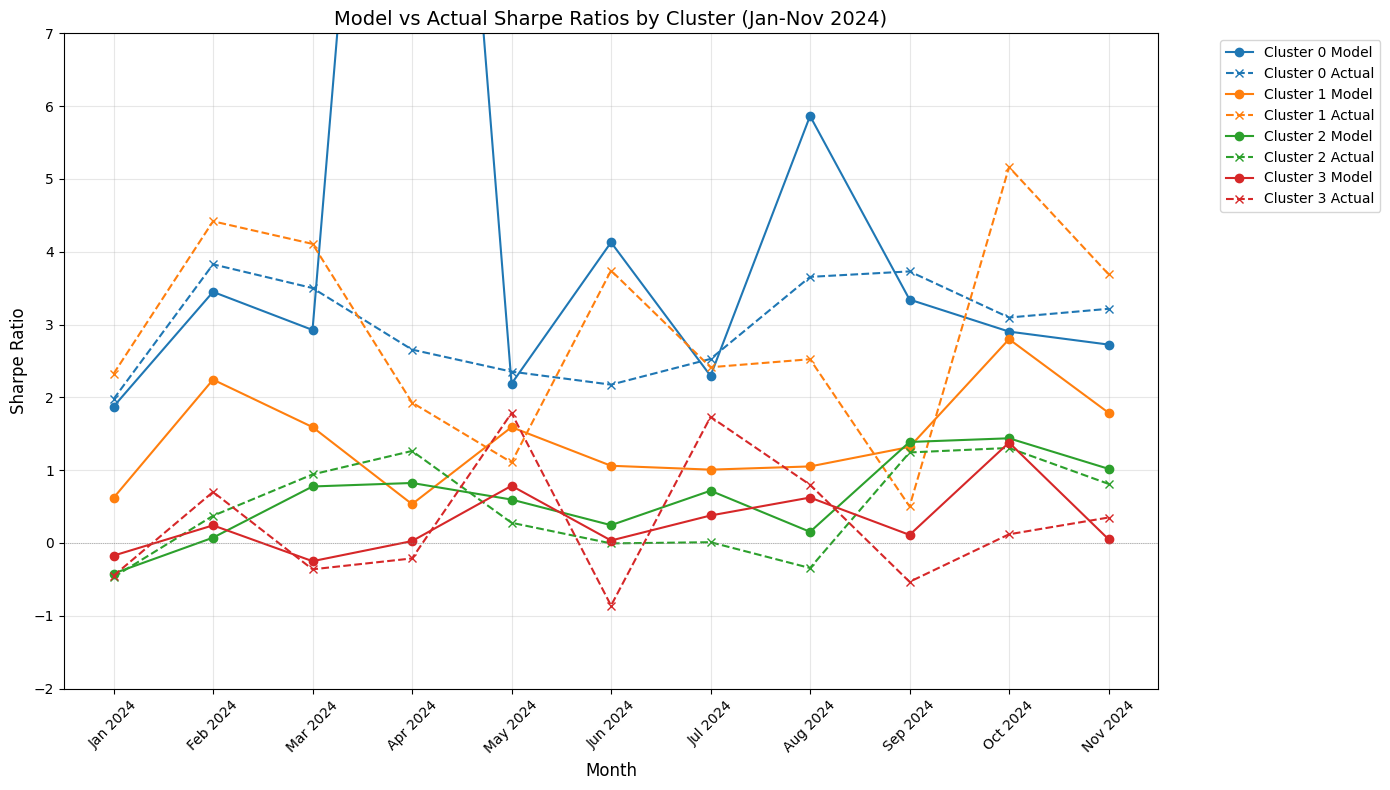

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# First ensure Month is in datetime format and sort
final_sharpe_df['Month'] = pd.to_datetime(final_sharpe_df['Month'], format='%b %Y')
final_sharpe_df = final_sharpe_df.sort_values('Month')

# Create month labels for x-axis
month_labels = final_sharpe_df['Month'].dt.strftime('%b %Y').unique()

plt.figure(figsize=(14, 8))

# Define colors and line styles
cluster_colors = {
    0: '#1f77b4',  # Blue
    1: '#ff7f0e',  # Orange
    2: '#2ca02c',  # Green
    3: '#d62728'   # Red
}

# Plot each cluster
for cluster in range(4):
    cluster_data = final_sharpe_df[final_sharpe_df.index % 4 == cluster]
    
    # Model SR
    plt.plot(month_labels,
             cluster_data['Sharpe Ratio'],
             color=cluster_colors[cluster],
             linestyle='-',
             marker='o',
             label=f'Cluster {cluster} Model')
    
    # Actual SR
    plt.plot(month_labels,
             cluster_data['Actual Sharpe Ratio'],
             color=cluster_colors[cluster],
             linestyle='--',
             marker='x',
             label=f'Cluster {cluster} Actual')

# Formatting
plt.title('Model vs Actual Sharpe Ratios by Cluster (Jan-Nov 2024)', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Sharpe Ratio', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Set y-axis limits to focus on relevant range
plt.ylim(-2, 7)

# Add legend and zero line
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axhline(y=0, color='gray', linestyle=':', linewidth=0.5)

plt.tight_layout()
plt.show()